In [1069]:
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from textwrap import wrap

In [797]:
def add_date_column(df):
    df['date'] = pd.to_datetime(df.created_at // 1000 // 60 // 60 // 24, unit='D')
    #df['date'] = df.date.dt.date
    
def drop_duplicate_entries(df):
    df.drop_duplicates(subset=['user_id', 'date', 'question', 'choice_id'], inplace=True)
    df.drop_duplicates(subset=['user_id', 'date', 'question'], keep=False, inplace=True)
    
def drop_creation_time_and_description(df):
    df.drop(columns=['created_at', 'description'], inplace=True)

def put_response_to_each_question_as_column(df):
    df = df.set_index(['user_id', 'date', 'question']).unstack()
    return df

def remove_incomplete_responses(df):
    df.dropna(inplace=True)

def simplify_column_names(df):
    df.columns = df.columns.droplevel(0)
    df.columns.names = [None]
    df.rename(columns={49: 'q49', 50: 'q50', 54: 'q54', 55: 'q55', 56: 'q56'}, inplace=True)
    
def set_user_and_date_as_column(df):
    df.reset_index(inplace=True)
    df.rename(columns={'user_id': 'userid'}, inplace=True)
    
def preprocess_survey_data():
    
    df = pd.read_feather('../data/01_raw/who5_responses.feather')

    add_date_column(df)
    drop_duplicate_entries(df)
    drop_creation_time_and_description(df)

    df = put_response_to_each_question_as_column(df)

    remove_incomplete_responses(df)
    simplify_column_names(df)
    set_user_and_date_as_column(df)    
    
    return df


def preprocess_vital_data():
    
    df = pd.read_feather('../data/01_raw/vitals.feather')
    
    df = df.set_index(['userid', 'date', 'deviceid', 'vitalid']).unstack()
    df.columns = df.columns.droplevel(0)
    df.columns.names = [None]

    df.reset_index(inplace=True)

    # Compute onset and offset
    df[52] = (pd.to_datetime(df[52], unit='s') - df['date']) / pd.Timedelta(hours=1)
    df[53] = (pd.to_datetime(df[53], unit='s') - df['date']) / pd.Timedelta(hours=1)
    
    # Correct for DST
    df.loc[(df.date <= '2021-10-31') | df.date.between('2022-03-28', '2022-10-30'), 52] += 1 
    df.loc[(df.date <= '2021-11-01') | df.date.between('2022-03-28', '2022-10-31'), 53] += 1 
    
    # Remove dates past the end of Datenspende
    df = df[df.date <= '2022-12-31']
    
    # Remove Apple sleep data
    df.loc[df.deviceid == 6, [43, 52, 53]] = np.nan
    
    # Remove outliers
    vmin = df.quantile(.025)
    vmax = df.quantile(.975)

    for vital in (9, 65, 43, 52, 53):
        df.loc[~df[vital].between(vmin[vital], vmax[vital]), vital] = np.nan
    
    
    return df

In [1067]:
wording = pd.read_feather('../data/01_raw/who5_responses.feather')
wording.drop(columns=['user_id', 'created_at', 'choice_id'], inplace=True)
wording.drop_duplicates(inplace=True)
wording.replace({i: f'q{i}' for i in wording.question}, inplace=True)
wording = {entry[0]: entry[1] for i, entry in wording.iterrows()}
wording['total_wellbeing'] = 'Mittleres Wohlbefinden'

In [823]:
survey = preprocess_survey_data()
vital = preprocess_vital_data()

In [824]:
entries = survey[['userid', 'date']]
devices = vital.deviceid.unique()

dummy_entries = pd.concat([entries] * len(devices))
dummy_entries['deviceid'] = np.repeat(devices, len(survey))

In [825]:
def compute(vital, min_periods=14, subset=''):
    
    if subset == 'weekend':
        vital = vital[vital.weekend]
    elif subset == 'weekday':
        vital = vital[~vital.weekend]
        
    vitalids = [65, 9, 43, 52, 53]
    columns = {i: f'v{i}{subset}' for i in vitalids}
    
    dummy = pd.concat([vital, dummy_entries]).reset_index(drop=True)
    dummy.drop_duplicates(subset=['userid', 'date', 'deviceid'], keep='first', inplace=True)

    g = dummy.set_index('date').sort_index().groupby(['userid', 'deviceid']).rolling('28D',  min_periods=min_periods)
    g = g[9, 43, 65, 52, 53].mean()
    
    g.rename(columns=columns, inplace=True)
    g.reset_index(inplace=True)
    
    return g

In [838]:
vital['weekend'] = vital.date.dt.dayofweek >= 5
survey['total_wellbeing'] = survey[['q49', 'q50', 'q54', 'q55', 'q56']].mean(axis=1)

g = compute(vital, 14)
m = pd.merge(survey, g, on=['userid', 'date'])

g = compute(vital, 4, 'weekend')
m = pd.merge(m, g, on=['userid', 'date', 'deviceid'])

g = compute(vital, 10, 'weekday')
m = pd.merge(m, g, on=['userid', 'date', 'deviceid'])

# Remove entries where no vital data exists
m = m[m.isna().sum(axis=1) < 15]

m['total_wellbeing'] = m[['q49', 'q50', 'q54', 'q55', 'q56']].mean(axis=1)
m['social_jetlag'] = 0.5 * (m['v53weekend'] + m['v52weekend'] - m['v53weekday'] - m['v52weekday'])
m['midsleep'] = 0.5 * (m['v53'] + m['v52'])

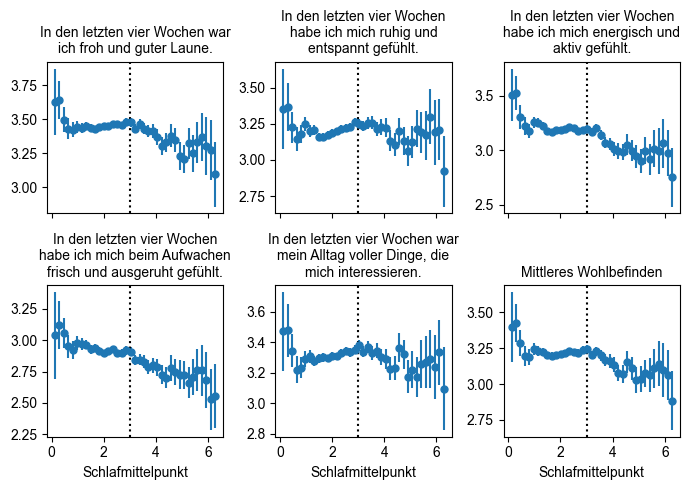

In [1107]:
f, axarr = plt.subplots(2, 3, sharex=True, figsize=(7,5))

label = {'v9': 'Schrittzahl', 'v65': 'Ruhepuls', 'v43': 'Schlafdauer', 
         'v52': 'Einschlafzeit', 'v53': 'Aufwachzeit', 'midsleep': 'Schlafmittelpunkt'}

vital_key = 'midsleep'
bins = 50
question_keys = ['q49', 'q50', 'q54', 'q55', 'q56', 'total_wellbeing']
marker = 3

for question_key, ax in zip(question_keys, axarr.flatten()):
    df = m[[vital_key, question_key]].dropna()

    df['bins'] = pd.cut(df[vital_key], bins)
    df.bins = df['bins'].apply(lambda x: x.left + 0.5 * (x.right - x.left))

    df = df.groupby(['bins'])[question_key].agg(['mean', 'count', 'std'])
    df['err'] = 1.96 * df['std'] / np.sqrt(df['count'])
    df = df[df['count'] > 50]
    
    ax.errorbar(df.index, df['mean'], yerr=df['err'], fmt='o', markersize=5)
    ax.set_title('\n'.join(wrap(wording[question_key], 30)), size=10)
    
    if marker:
        ax.axvline(marker, c='k', ls=':')
    
for ax in axarr[1]:
    ax.set_xlabel(label[vital_key])
    
plt.tight_layout()